In [1]:
# import packages
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import Bio
import statsmodels.api as sm
import re

Import modified dataframes (clean up process is seen in /finished_jupyter folder)

In [2]:
# import data 
path: str = './data/' #folder where files are stored
prokaryotes: pd.DataFrame = pd.read_csv(os.path.join(path, "prokaryotes_unique_prot.csv"), dtype=str)   
prokaryotes_all: pd.DataFrame = pd.read_csv(os.path.join(path, "prokaryotes_all.csv"), dtype=str)

Calculate relative abundance of hydrophobic aminoacids for each protein and append to dataframe

In [3]:
from function import rel_aa_comp
from Aminoacid_lists import AA_hydrophobic, AA_polar_neutral, AA_acidic, AA_basic
prokaryotes['hydrophobic'] = prokaryotes['Sequence'].apply(lambda x: rel_aa_comp(x, AA_hydrophobic)) # calculates relative amino acid composition of hydrophobic amino acids
prokaryotes['polar_neutral'] = prokaryotes['Sequence'].apply(lambda x: rel_aa_comp(x, AA_polar_neutral)) # calculates relative amino acid composition of polar neutral amino acids
prokaryotes['acidic'] = prokaryotes['Sequence'].apply(lambda x: rel_aa_comp(x, AA_acidic)) # calculates relative amino acid composition of acidic amino acids
prokaryotes['basic'] = prokaryotes['Sequence'].apply(lambda x: rel_aa_comp(x, AA_basic)) # calculates relative amino acid composition of basic amino acids



Group dataframes based on run name

In [4]:
prokaryotes_all_group = prokaryotes_all.groupby('run_name')
prokaryotes_group = prokaryotes.groupby('run_name')




Some plots to test data

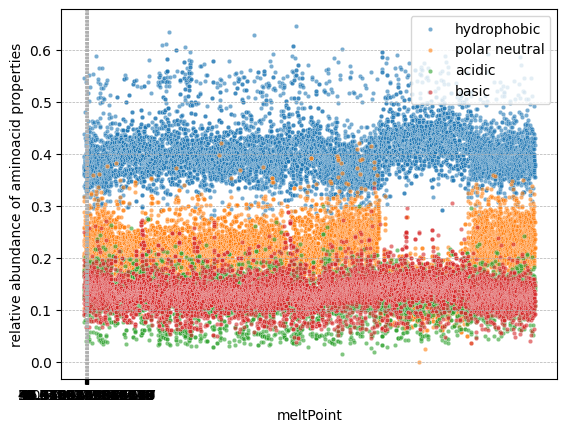

In [5]:
sns.scatterplot(data = prokaryotes, x = 'meltPoint', y = 'hydrophobic', label = 'hydrophobic', s= 10, alpha = 0.6)
sns.scatterplot(data=prokaryotes, x='meltPoint', y='polar_neutral', label = 'polar neutral', s= 10, alpha = 0.6)
sns.scatterplot(data= prokaryotes, x='meltPoint', y='acidic', label = 'acidic', s= 10, alpha = 0.6)
sns.scatterplot(data=prokaryotes, x='meltPoint', y='basic', label = 'basic', s= 10, alpha = 0.6)
plt.xticks(np.arange(30, 100, 5))
plt.ylabel('relative abundance of aminoacid properties')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()



Calculate average hydrophic content for each organism and plot vs living temperature of organism

prokaryotes_average = prokaryotes_group.mean(['temperature', 'hydrophobic', 'acidic', 'polar_neutral', 'basic'])
prokaryotes_average = prokaryotes_average.reset_index()

#plot hydrophobic agaisnt temp
sns.scatterplot(data = prokaryotes_average, x = 'temperature', y = 'hydrophobic', hue = 'run_name', s= 50, alpha = 0.9)
plt.legend(loc= 'lower right', bbox_to_anchor=(1.8, -0.01))  
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

#Plot polar_neutral against temp
sns.scatterplot(data = prokaryotes_average, x = 'temperature', y ='polar_neutral', hue = 'run_name', s= 50, alpha = 0.9)
plt.legend(loc= 'lower right', bbox_to_anchor=(1.8, -0.01))  
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

#Plot acidic against temp
sns.scatterplot(data = prokaryotes_average, x = 'temperature', y ='polar_neutral', hue = 'run_name', s= 80, alpha = 0.9)
plt.legend(loc= 'lower right', bbox_to_anchor=(1.8, -0.01))  
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

#Plot basic against temp
sns.scatterplot(data = prokaryotes_average, x = 'temperature', y ='polar_neutral', hue = 'run_name', s= 80, alpha = 0.9)
plt.legend(loc= 'lower right', bbox_to_anchor=(1.8, -0.01))  
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

Test for lysine and aspartic acid as indicator for stable and unstable proteins, respectively

prokaryotes['Asp'] = prokaryotes['Sequence'].apply(lambda x: rel_aa_comp(x, ['D'])) # calculates relative Asp abundance
prokaryotes['Lys'] = prokaryotes['Sequence'].apply(lambda x: rel_aa_comp(x, ['K'])) # calculates relative Glu abundance

#plot individual proteins
sns.scatterplot(data=prokaryotes, x='meltPoint', y='Asp', label = 'Asp', s= 10, alpha = 1)
sns.scatterplot(data=prokaryotes, x='meltPoint', y='Lys', label = 'Lys', s= 10, alpha = 1)
plt.xticks(np.arange(30, 100, 5))
plt.ylabel('relative abundance of aminoacid properties')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

#avg protein of each organism
prokaryotes_average = prokaryotes_group.mean(['temperature', 'hydrophobic', 'acidic', 'polar_neutral', 'basic', 'Asp', 'Lys'])
prokaryotes_average = prokaryotes_average.reset_index()


#plot avg Asp contant of each organism agaisnt OGT
sns.scatterplot(data = prokaryotes_average, x = 'temperature', y = 'Asp', hue = 'run_name', s= 50, alpha = 0.9)
plt.legend(loc= 'lower right', bbox_to_anchor=(1.8, -0.01))  
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

#plot avg Lys contant of each organism agaisnt OGT
sns.scatterplot(data = prokaryotes_average, x = 'temperature', y = 'Lys', hue = 'run_name', s= 50, alpha = 0.9)
plt.legend(loc= 'lower right', bbox_to_anchor=(1.8, -0.01))  
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()


In [6]:
mgt = {"Thermus thermophilus HB27 cells" : float(85),
        "Thermus thermophilus HB27 lysate" : float(85),
        "Oleispira antarctica_RB-8_lysate_R1" : float(27),  # Modified key to match the actual value
        "Picrophilus torridus DSM9790 lysate" : float(67),
        "Escherichia coli cells" : float(47),
        "Escherichia coli lysate" : float(47),
        "Bacillus subtilis_168_lysate_R1" : float(52),
        "Geobacillus stearothermophilus NCA26 lysate" : float(65)}

for n in range(len(prokaryotes)):
        prokaryotes.loc[n, 'mgt'] = mgt[prokaryotes.loc[n, 'run_name']]


In [7]:
secstr = prokaryotes.dropna(thresh=1,subset=['Helix', 'Turn', 'Beta strand'])
pattern = r'\b\d+\.\.\d+\b'
tempt = re.findall(pattern, secstr.iloc[0,19])
print(tempt[0])
pattern2 = r'\b\d+\b'
tempt2 = re.findall(pattern2, tempt[0])
tempt2 = list(map(int, tempt2))
print(list(range(tempt2[0], tempt2[1]+1)))
print(secstr.iloc[0,19])

24..26
[24, 25, 26]
HELIX 24..26; /evidence="ECO:0007829|PDB:2E8Y"; HELIX 89..92; /evidence="ECO:0007829|PDB:2E8Y"; HELIX 94..100; /evidence="ECO:0007829|PDB:2E8Y"; HELIX 147..149; /evidence="ECO:0007829|PDB:2E8Y"; HELIX 187..189; /evidence="ECO:0007829|PDB:2E8Y"; HELIX 212..214; /evidence="ECO:0007829|PDB:2E8Y"; HELIX 222..227; /evidence="ECO:0007829|PDB:2E8Y"; HELIX 239..243; /evidence="ECO:0007829|PDB:2E8Y"; HELIX 256..263; /evidence="ECO:0007829|PDB:2E8Y"; HELIX 284..286; /evidence="ECO:0007829|PDB:2E8Y"; HELIX 311..327; /evidence="ECO:0007829|PDB:2E8Y"; HELIX 344..346; /evidence="ECO:0007829|PDB:2E8Y"; HELIX 348..352; /evidence="ECO:0007829|PDB:2E8Y"; HELIX 381..398; /evidence="ECO:0007829|PDB:2E8Y"; HELIX 408..410; /evidence="ECO:0007829|PDB:2E8Y"; HELIX 413..426; /evidence="ECO:0007829|PDB:2E8Y"; HELIX 445..447; /evidence="ECO:0007829|PDB:2E8Y"; HELIX 451..456; /evidence="ECO:0007829|PDB:2E8Y"; HELIX 465..472; /evidence="ECO:0007829|PDB:2E8Y"; HELIX 483..485; /evidence="ECO:0007

In [8]:
secstr['Helixbesser']=pd.Series(dtype=object)
secstr['Sheetbesser']=pd.Series(dtype=object)
secstr['Turnbesser']=pd.Series(dtype=object)

C:\Users\tobia\AppData\Local\Temp\ipykernel_18680\411653847.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  secstr['Helixbesser']=pd.Series(dtype=object)
C:\Users\tobia\AppData\Local\Temp\ipykernel_18680\411653847.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  secstr['Sheetbesser']=pd.Series(dtype=object)
C:\Users\tobia\AppData\Local\Temp\ipykernel_18680\411653847.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer

In [9]:
np.isnan(secstr.iloc[20,19])

True

In [10]:
pattern = r'\b\d+\.\.\d+\b'
pattern2 = r'\b\d+\b'
#filling column helixbesser
for n in range(len(secstr)):
    templist = []
    if pd.isnull(secstr.iloc[n, 19]) == False:
        tempt = re.findall(pattern, secstr.iloc[n, 19])
        for m in range(len(tempt)):    
            tempt2 = re.findall(pattern2, tempt[m])
            tempt2 = list(map(int, tempt2))
            templist.append(list(range(tempt2[0], tempt2[1]+1)))
        secstr.iat[n, 29] = templist
    else: 
        secstr.iat[n, 29] = np.nan
            
#filling column sheetbesser
for n in range(len(secstr)):
    templist = []
    if pd.isnull(secstr.iloc[n, 18]) == False:
        tempt = re.findall(pattern, secstr.iloc[n, 18])
        for m in range(len(tempt)):    
            tempt2 = re.findall(pattern2, tempt[m])
            tempt2 = list(map(int, tempt2))
            templist.append(list(range(tempt2[0], tempt2[1]+1)))
        secstr.iat[n, 30] = templist
    else: 
        secstr.iat[n, 30] = np.nan
#filling column turnbesser
for n in range(len(secstr)):
    templist = []
    if pd.isnull(secstr.iloc[n, 17]) == False:
        tempt = re.findall(pattern, secstr.iloc[n, 17])
        for m in range(len(tempt)):    
            tempt2 = re.findall(pattern2, tempt[m])
            tempt2 = list(map(int, tempt2))
            templist.append(list(range(tempt2[0], tempt2[1]+1)))
        secstr.iat[n, 31] = templist
    else: 
        secstr.iat[n, 31] = np.nan

In [11]:
dumm = secstr.copy()
dumm['helixbesser'] = pd.Series(dtype=object)
dumm.iat[0,30]=[[1,2,3],[4,5,6]]
print(dumm.iloc[0,30][1])

[4, 5, 6]


In [12]:
proj3 = pd.DataFrame()
prokaryotes['meltPoint'] = prokaryotes['meltPoint'].astype('float64')

In [13]:
qwer = []
for n in range(len(prokaryotes)):
    if pd.isnull(prokaryotes.iloc[n,11]) == False:
        if prokaryotes.iloc[n,11] >= prokaryotes.iloc[n,28] -1 and prokaryotes.iloc[n,11] <= prokaryotes.iloc[n,28] +1:
            qwer.append(n)
proj3 = prokaryotes.iloc[qwer,:]